# 🧑🏻‍💻 How to train a (deep learning) model in PyTorch

[Deep Learning](https://dsai.units.it/index.php/courses/deep-learning/) Course @ [UniTS](https://portale.units.it/en), Spring 2024

<a target="_blank" href="https://colab.research.google.com/github/emaballarin/deeplearning-units/blob/main/labs/02_gradient_based_training.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>  <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/emaballarin/deeplearning-units/blob/main/labs/02_gradient_based_training.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

## Introduction

![itstraining.png](https://i.redd.it/5cjdqxcg07k11.png)
<br><sub><sup>From <a href="https://www.reddit.com/r/ProgrammerHumor/comments/9cu51a/shamelessly_stolen_from_xkcd_credit_where_is_due/">/r/ProgrammerHumor (September 8th, 2018)</a></sup></sub>

In today's lab, we will learn how to train a model in PyTorch (*i.e.* a `torch.nn.Module`). Most of the future laboratories will build upon this one, since training a model is a crucial part of deep learning.  

Just to be extra clear: here, by *training a model* we mean the process of finding the approximately-best parameters for a model, given a task to be solved, usually some data, and eventually some external constraint (*e.g.* time, compute availability, etc...). This is done by minimizing a loss function, which measures how well the model is performing, usually by first-order methods.

### Preliminary infrastucture setup

Nothing new here, just the usual cloud-aware setup...

In [1]:
import os

FOLDERNAME: str = "deeplearning_units_2024"
try:
    if os.getenv("COLAB_RELEASE_TAG"):
        # noinspection PyUnresolvedReferences
        from google.colab import drive

        drive.mount(BASEPATH := "/content/drive")
        os.makedirs(FULLPATH := BASEPATH + "/MyDrive/" + FOLDERNAME, exist_ok=True)
    elif os.getenv("KAGGLE_CONTAINER_NAME"):
        os.makedirs(FULLPATH := "/kaggle/working/" + FOLDERNAME, exist_ok=True)
    else:
        os.makedirs(FULLPATH := "./" + FOLDERNAME, exist_ok=True)
    os.chdir(FULLPATH)
except (ModuleNotFoundError, FileExistsError, FileNotFoundError):
    pass

### The imports for the day

In [2]:
import numpy as np

import torch as th

from torch.utils.data import DataLoader

import torchvision as tv
from torchvision import datasets
from torchvision import transforms

from ebtorch.nn.utils import eval_model_on_test

import matplotlib.pyplot as plt


from tqdm.auto import trange

from typing import List, Union, Callable

## The *typical* model training *pipeline*

> *`Model training` est divisus in partes tres*:
> - the **task** (which eventually includes actual **data**),
> - the **model** (and associated **loss function**),
> - the **optimization process**.

In [3]:
# Useful hyperparameters
DEVICE_AUTODETECT: bool = True
TRAIN_BATCH_SIZE: int = 128
TEST_BATCH_SIZE: int = int(1e4)
EPOCHS: int = 10
CRITERION: Union[th.nn.Module, Callable[[th.Tensor], th.Tensor]] = (
    th.nn.CrossEntropyLoss()
)
LR: float = 2e-3

In [4]:
# Let's detect and select the most appropriate device
# (adapt it to your specific hardware needs: mps, tpu, ...)
device: th.device = th.device(
    "cuda" if th.cuda.is_available() and DEVICE_AUTODETECT else "cpu"
)

### The data

Training a deep learning model almost always requires some data. Even though, in principle, nothing prevents you from carrying around data in `torch.Tensor`s, PyTorch provides two handy classes to handle data in a more structured way.

They are `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`. The former constitutes an abstraction over the actual dataset, composed of the atomic data-units seen by the model during training; the latter is a wrapper around the `Dataset`, which defines how data are accessed, and allows for parallel data loading, shuffling, and other useful features.

Unless you have very stringent reasons to do otherwise, you should always use these classes to handle your data.

In case you need to implement your own `Dataset`, remember that it should inherit from `torch.utils.data.Dataset` and implement the `__len__` and `__getitem__` methods. More info about custom `Dataset`s can be found [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) and [here](https://pytorch.org/docs/stable/data.html).

In this lab, we will use the famous `MNIST` dataset, which is composed of labelled handwritten digits. It is a very common benchmark dataset, so that it is directly included as a `Dataset` in the `torchvision` package.

The task will be, indeed, handwritten digit classification.

**Remark:** The `transforms` we are using are meant to convert the images into `torch.Tensor`s (`ToTensor()`) and to normalize the images to have 0 mean and standard deviation 1 (`Normalize(mean, stddev)`).

**Remark:** The `batch_size` argument allows us to setup mini-batched model training. If we define a batch_size of 128, it means that at each training step the network is fed with 128 datapoints from our dataset, on which an optimization step will be performed. The choice of batch size may dramatically affect the training process (all other hyperparameters being constant), and even though there is still debate around whether it should be treated as a tunable hyperparameter, it balances memory efficiency and effective gradient noise. Generally speaking, [one should aim for the highest batch size that fits in memory](https://arxiv.org/abs/1811.03600), and then tune optimization parameters to adapt the learning process as needed.

In [5]:
mnist_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

os.makedirs("./data/", exist_ok=True)

train_dataset = datasets.MNIST(
    root="./data", train=True, transform=mnist_transforms, download=True
)
test_dataset = datasets.MNIST(
    root="./data", train=False, transform=mnist_transforms, download=True
)

train_loader: DataLoader = DataLoader(
    dataset=train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True
)
test_loader: DataLoader = DataLoader(
    dataset=test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False
)

100%|██████████| 9912422/9912422 [00:03<00:00, 3045578.83it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 9054166.52it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


100%|██████████| 1648877/1648877 [00:00<00:00, 7205832.48it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 2059294.00it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw


Let's have a look at the data we just loaded.

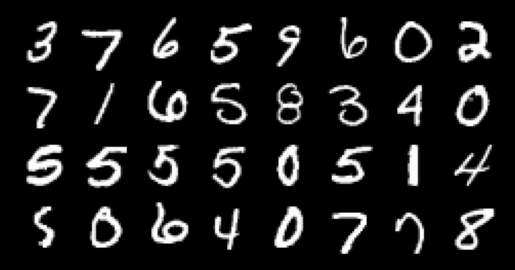

In [6]:
def imshow(img) -> None:
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, axes=(1, 2, 0)))


# Get some random training images
dataiter = train_loader.__iter__()
images, labels = dataiter.__next__()

# Show grid of images
imshow(tv.utils.make_grid(images[: 8 * 4], normalize=True))

In [7]:
# Let's see the associated labels
print(f"Labels: {labels[:8*4]}")

Labels: tensor([3, 7, 6, 5, 9, 6, 0, 2, 7, 1, 6, 5, 8, 3, 4, 0, 5, 5, 5, 5, 0, 5, 1, 4,
        5, 0, 6, 4, 0, 7, 7, 8])


In [8]:
# Let's see the shape of the images
print(f"Images shape: {images.shape}")

Images shape: torch.Size([128, 1, 28, 28])


### The model

In `PyTorch`, we usually define a model by subclassing the `nn.Module` class and defining the `forward` method. The `forward` method is where we define the *computation* that happens at every *forward pass* of the model.

Except for extreme corner-cases, the backward pass is automatically defined by `PyTorch` *autograd* system and gradients are obtained efficiently whenever needed.

`PyTorch` modules are *transparent* with respect to batch sizes, i.e. we can use the same model to process a single sample or a batch of samples, without worrying about the exact batch size.

Let's define a simple **1-hidden-layer multilayer perceptron** as an example. Apart from specific peculiarities, the rest of the notebook should be general enough to be applied to any model.

In our case, the MLP will have a hidden layer of 128 neurons, with ReLU activations. The input layer has size is 784 (since our images are 1x28x28), and the output layer has 10 (since we have 10 possible classes).

The ReLU is the Rectified Linear Unit, defined as:
$$
\text{ReLU}(x) = \max(0, x) = \begin{cases}x & \text{ if } x \geq 0 \\0 & \text{ if } x < 0\end{cases}
$$

In [9]:
class MyMLP(th.nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super().__init__()

        # Affine linear transform sub-module: input-to-hidden
        self.fc1: th.nn.Module = th.nn.Linear(
            in_features=input_size, out_features=hidden_size, bias=True
        )

        # Affine linear transform sub-module: hidden-to-output
        self.fc2: th.nn.Module = th.nn.Linear(hidden_size, output_size, bias=True)

    def forward(self, x_: th.Tensor) -> th.Tensor:
        x_ = th.flatten(x_, start_dim=1)  # Keep batch dimension, flatten the rest
        # I.e.: (N, C, H, W) -> (N, C*H*W)

        x_ = self.fc1(x_)  # Apply first linear transformation
        x_ = th.nn.functional.relu(x_)  # Apply ReLU activation
        # Activation functions are usually applied elementwise

        x_ = self.fc2(x_)  # Apply second linear transformation

        # N.B.: outputs are [-inf, +inf]; e.g. to be used as logits
        return x_


# But we won't use this model in this notebook, so...
del MyMLP

By sacrificing some flexibility in the definition of the `forward` pass, one could also define a model via the `torch.Sequential` API, which is much more compact. The `nn.` elements usually mirror their equivalent `torch.nn.functional.` counterparts.

From the computational viewpoint, the approaches are almost identical. Sometimes, `nn.Sequential` objects support more built-in abstractions, given their stricter structure (*e.g.* in-order network layer iteration).

In our case, the same model is easily translated into a `Sequential` object.

In [10]:
def define_myseqmlp(
    input_size: int, hidden_size: int, output_size: int
) -> th.nn.Sequential:
    return th.nn.Sequential(
        th.nn.Flatten(start_dim=1),  # Flatten the input
        th.nn.Linear(
            in_features=input_size, out_features=hidden_size, bias=True
        ),  # First linear transformation
        th.nn.ReLU(),  # ReLU activation
        th.nn.Linear(
            hidden_size, output_size, bias=True
        ),  # Second linear transformation
    )

#### The loss function

A crucial element needed to train any model is the *loss function*, *i.e.* a function that quantifies how well our model solves our task on some given data. In the context of Deep Learning, a loss function should be differentiable (at least in the algorithmic sense) *w.r.t.* the learnable parameters of the model.

PyTorch already provides many commonly-used loss functions, which can be found in the `torch.nn` module (as `nn.Module`s) or in the `torch.nn.functional` module (as functions). You can find a list of the former in the [official documentation](https://pytorch.org/docs/stable/nn.html#loss-functions).

You can also define your own custom loss function. It should at least be callable and return a `torch.Tensor`. As long as you create it using built-in `torch` functions, it should also be differentiable... and you are good to go!

As an example, you could build your own MSE loss like this (but please, do yourself a favour and use that already - and more efficiently - implemented in PyTorch!):

In [11]:
def mseloss(output: th.Tensor, target: th.Tensor) -> th.Tensor:
    return th.mean((output - target) ** 2)


del mseloss

In our case, we will use the `CrossEntropyLoss`, as we are dealing with a classification task.


You can find the specifics of this *loss* in PyTorch [here](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html), but what is really worth pointing out is that it is assumed that the input(s) are *'raw, unnormalized scores for each class'*. This means that we shouldn't include any softmax in the network architecture, since it is already included by this implementation of the CE loss!

Or we could include it, but then we should use the [`NLLLoss`](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html) (Negative Log-Likelihood Loss) instead.

### The optimization process

With the `autodiff` engine allowing us to compute gradients of (almost) any function - specifically, we will be interested the loss function of our model -, it is time to figure out what to do with these gradients!

In PyTorch, it is straightforward to apply most first-order optimization techniques - *e.g.* Gradient Descent and its variations, such as SGD, Adam, RMSProp *etc...* - to the parameters of an `nn.Model`.

The `torch.optim` module provides a set of classes implementing some of these algorithms, which can be found [here](https://pytorch.org/docs/stable/optim.html#algorithms).

However, before building and applying such an optimizer to our model, we need to instantiate the actual model and move it to the device we are using.

In [12]:
# In our case...
model: th.nn.Module = define_myseqmlp(28 * 28, 127, 10).to(
    device
)  # Remember to move the model to the appropriate device!
# By default, it is on the CPU.

In [13]:
# Let's define the optimizer
optimizer: th.optim.Optimizer = th.optim.Adam(
    params=model.parameters(), lr=LR, weight_decay=0
)

Using an optimizer is generally very simple. There are three main steps involved:

- zeroing any current gradient information left attached to the parameters: `optimizer.zero_grad()`,
- computing the derivatives of the loss *w.r.t.* the parameters and storing such gradient information: `loss.backward()`,
- performing a parameter update step in the loss-minimizing direction: `optimizer.step()`.

Note that the first step should always be performed unless we do want PyTorch to accumulate gradients!

#### Learning rate scheduling

In practice, it is often useful to vary the learning rate during training. For example you may want to use a large learning rate in the initial phase of training to quickly descend the loss and then you may want to decrease it to be more precise around a minimum.

This can be done in many ways, but the most common is to use a *learning rate scheduler*. In PyTorch, a learning rate scheduler is an object that takes an optimizer and updates the learning rate according to some rule. You can find the list of available schedulers in the [official documentation](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate).

The simplest LR scheduler is `torch.optim.lr_scheduler.ExponentialLR`, which takes an existing optimizer (with learning rate $\lambda$) and a parameter $\gamma$. It multiplies the learning rate by $\gamma$ every given time `scheduler.step()` is called (*e.g.* at every batch, or at every epoch). *I.e.:*

$$
\lambda_{\text{i+1}} \leftarrow \gamma\lambda_{\text{i}}
$$

In [14]:
# Let's define the scheduler
scheduler: th.optim.lr_scheduler.LRScheduler = th.optim.lr_scheduler.ExponentialLR(
    optimizer=optimizer, gamma=0.95
)

### The (actual) training loop
```
Loop over epochs:
    Loop over data:
        Perform a forward pass
        Compute the loss
        Zero-out past gradients
        Perform a backward pass
        Update model parameters
       (Update the learning rate)
   (Compute validation metric)
```

Gradient-based training is an iterative process, that we repeat for a (usually) fixed number of epochs. At each epoch, we traverse the whole dataset by randomly drawn mini-batches of a fixed number of elements.

In [15]:
eval_losses: List[float] = []
eval_acc: List[float] = []
test_acc: List[float] = []

# Loop over epochs
for epoch in trange(EPOCHS, desc="Training epoch"):

    model.train()  # Remember to set the model in training mode before actual training

    # Loop over data
    for batch_idx, batched_datapoint in enumerate(train_loader):

        x, y = batched_datapoint
        x, y = x.to(device), y.to(device)

        # Forward pass + loss computation
        yhat = model(x)
        loss = CRITERION(yhat, y)

        # Zero-out past gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()

    # Log the loss and accuracy on the training set...
    num_elem: int = 0
    trackingmetric: float = 0
    trackingcorrect: int = 0

    model.eval()  # Remember to set the model in evaluation mode before evaluating it

    # Since we are just evaluating the model, we don't need to compute gradients
    with th.no_grad():
        # ... by looping over training data again
        for _, batched_datapoint_e in enumerate(train_loader):
            x_e, y_e = batched_datapoint_e
            x_e, y_e = x_e.to(device), y_e.to(device)
            modeltarget_e = model(x_e)
            ypred_e = th.argmax(modeltarget_e, dim=1, keepdim=True)
            trackingmetric += CRITERION(modeltarget_e, y_e).item()
            trackingcorrect += ypred_e.eq(y_e.view_as(ypred_e)).sum().item()
            num_elem += x_e.shape[0]
        eval_losses.append(trackingmetric / num_elem)
        eval_acc.append(trackingcorrect / num_elem)

    # Let's ignore for now what the next line does... 🙈
    test_acc.append(
        eval_model_on_test(
            model, True, test_loader, device, th.nn.CrossEntropyLoss(), False
        )
    )

Training epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Notice the `model.train()` and `model.eval()` calls, and the `torch.no_grad()` context manager.

The former two inform the model (and its submodules) that we are either training or evaluating it. This is important because some modules are developed to behave differently during training and evaluation (*e.g.* dropout, batch normalization, etc...).

The latter switches off gradient-tracking operations: this allows to make computations lighter and to avoid performing gradient descent steps by mistake.

### Final evaluation

Let's see how the loss and accuracy of the model - evaluated on the **training set** - evolved during the training process.

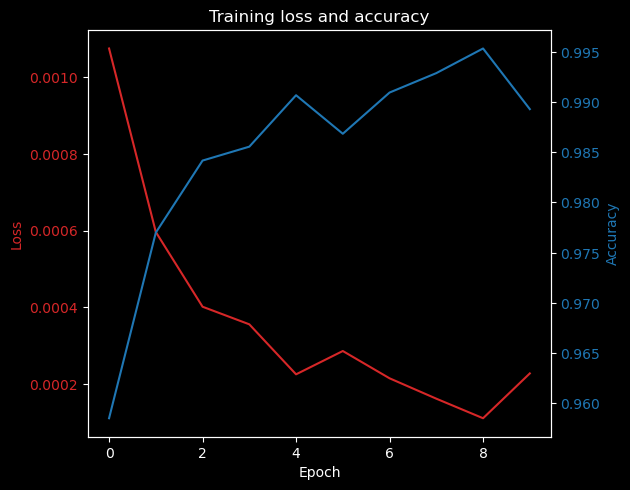

In [16]:
loss_color = "tab:red"
acc_color = "tab:blue"

fig, ax1 = plt.subplots()

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color=loss_color)
ax1.plot(eval_losses, color=loss_color)
ax1.tick_params(axis="y", labelcolor=loss_color)

ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy", color=acc_color)
ax2.plot(eval_acc, color=acc_color)
ax2.tick_params(axis="y", labelcolor=acc_color)

fig.tight_layout()

plt.title("Training loss and accuracy")
plt.show()

In [17]:
print(f"Final training loss: {eval_losses[-1]}")
print(f"Final training accuracy: {eval_acc[-1]}")

Final training loss: 0.00022702794022091743
Final training accuracy: 0.9892833333333333


Accuracy on the training set is not a good indicator of the model's performance. We should evaluate it on the **test set** to have a more reliable estimate of the model's generalization capabilities.

In [18]:
# Let's evaluate the model on the test set
model.eval()
num_elem: int = 0
trackingcorrect: int = 0

with th.no_grad():
    for _, batched_datapoint_e in enumerate(test_loader):
        x_e, y_e = batched_datapoint_e
        x_e, y_e = x_e.to(device), y_e.to(device)
        modeltarget_e = model(x_e)
        ypred_e = th.argmax(modeltarget_e, dim=1, keepdim=True)
        trackingcorrect += ypred_e.eq(y_e.view_as(ypred_e)).sum().item()
        num_elem += x_e.shape[0]

In [19]:
print(f"Final test accuracy: {trackingcorrect / num_elem}")

Final test accuracy: 0.9695


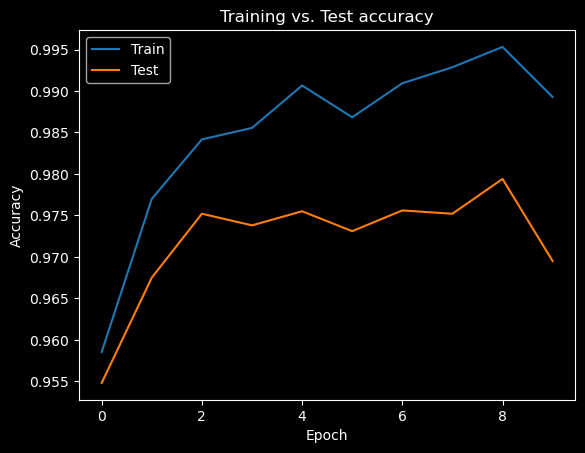

In [20]:
# Let's plot the accuracy on the train vs test set

fig, ax = plt.subplots()

ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.plot(eval_acc, label="Train", color="tab:blue")
ax.plot(test_acc, label="Test", color="tab:orange")
ax.legend()

plt.title("Training vs. Test accuracy")
plt.show()